In [2]:
import re
import json
import csv
import os
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt

In [12]:
# Function to tokenize a single word
def tokenize(word):
    return re.findall(r'[^\s\W]+', word)

# Step 1: Read the text data
def read_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        data = file.readlines()
    return data

# Step 2: Parse the text data into sentences and corresponding tags
def parse_data(data):
    sentences = []
    tags = []
    current_sentence = []
    current_tags = []
    for line in data:
        line = line.strip()
        if line:  # Non-empty line
            word, tag = line.split('\t')[-2:]
            current_sentence.append(word)
            current_tags.append(tag)
        else:  # Empty line indicates end of sentence
            sentences.append(current_sentence)
            tags.append(current_tags)
            current_sentence = []
            current_tags = []
    return sentences, tags

# Step 3: Tokenize the sentences
def tokenize_sentences(sentences):
    tokenized_sentences = []
    for sentence in sentences:
        tokenized_sentence = [tokenize(word) for word in sentence]
        tokenized_sentences.append(tokenized_sentence)
    return tokenized_sentences

# Step 4: Convert words and tags into numerical format
def convert_to_numerical(sentences, tags, word_to_idx, tag_to_idx):
    X = [[word_to_idx.get(tuple(word), len(word_to_idx)) for word in sentence] for sentence in sentences]
    
    # Find the maximum length of the input sequences
    max_len = max(len(seq) for seq in X)
    max_index = max(max(seq) for seq in train_X)
    print("Maximum index in train_X:", max_index)
    
    # Pad the input sequences to match the maximum length
    padded_X = []
    for seq in X:
        padded_seq = seq + [0] * (max_len - len(seq))
        padded_X.append(padded_seq)
    
    # Convert tags to uppercase
    tags = [[tag.upper() for tag in tag_seq] for tag_seq in tags]
    
    # Pad the label sequences to match the maximum length
    padded_y = []
    for tag_seq in tags:
        padded_seq = [tag_to_idx[tag] for tag in tag_seq] + [0] * (max_len - len(tag_seq))
        padded_y.append(padded_seq)
    
    return padded_X, padded_y


# Function to build vocabulary
def build_vocab(data):
    vocab = set()
    tags = set()
    for line in data:
        # Skip empty lines
        if not line.strip():
            continue
        # Split the line into word, characters, and tag
        parts = line.split()
        word = parts[0]
        chars = ' '.join(parts[1:-1])  # Combine characters if there are more than one
        tag = parts[-1]
        # Add the word, characters, and tag to the respective vocabularies
        vocab.add(word)
        vocab.update(chars.split())
        tags.add(tag)
    return vocab, tags

# Read data from train, test, and validate files
def read_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        data = file.readlines()
    return data

# Read train data
train_data = read_data('DATA/Kannada-train.txt')
# # Read test data
test_data = read_data('DATA/Kannada-test.txt')
# # Read validate data
#validate_data = read_data('DATA/Kannada-validate.txt')

# Merge train, test, and validate datasets if needed
merged_data = train_data + test_data

# Build the vocabulary and tags
vocab, tags = build_vocab(merged_data)

# Print the vocabulary size and some sample words
print("Vocabulary size:", len(vocab))
print("Sample words from the vocabulary:", list(vocab)[:10])

# Print the tags and their corresponding indices
print("Tags:", tags)

# Print the size of the tag vocabulary
print("Tag vocabulary size:", len(tags))

# Define tag_to_idx mapping, including the missing 'O' tag
tag_to_idx = {'<PAD>': 0, 'B-LOC': 1, 'B-COM': 2, 'O': 3, 'I-PER': 4, 'I-LOC': 5, 'I-ORG': 6, 'B-PER': 7, 'I-COM': 8, 'B-DATE': 9, 'B-ROL': 10, 'B-ORG': 11, 'I-ROL': 12, 'B-NUM': 13}

word_to_idx = {word: idx for idx, word in enumerate(vocab)}

word_to_idx['<PAD>'] = 0
tag_to_idx['<PAD>'] = 0

train_sentences, train_tags = parse_data(train_data)
# Define train_X and train_y before calling convert_to_numerical
train_X = tokenize_sentences(train_sentences)
train_X, train_y = convert_to_numerical(train_X, train_tags, word_to_idx, tag_to_idx)

Vocabulary size: 41542
Sample words from the vocabulary: ['ಪ್ರವಾಸಿಗ', 'ಕವಲೇದುರ್ಗದಲ್ಲಿ', 'ವಿಚಾರಣೆಗೆ', 'ಸೇವಕರನ್ನು', 'ಬಖಾರ್', 'ಜ್ಯೋತಿಷಿಗಳ', 'ಬರುತ್ತಿರಲಿಲ್ಲ', 'ತಲೆಯೆತ್ತಿದ್ದ', 'ಪ್ರಚೀನ', 'ಚಿ']
Tags: {'I-PER', 'B-NUM', 'B-LOC', 'I-ROL', 'o', 'B-COM', 'B-ROL', 'I-LOC', 'I-ORG', 'B-PER', 'B-ORG', 'B-DATE', 'O', 'I-COM'}
Tag vocabulary size: 14
Maximum index in train_X: ['೯', '೯']


In [13]:
json_dir = 'JSON'
os.makedirs(json_dir, exist_ok=True)

# Preprocess the data
train_X, train_y = convert_to_numerical(train_sentences, train_tags, word_to_idx, tag_to_idx)

# Define function to save data to JSON
def save_data_to_json(data, file_path):
    with open(file_path, 'w', encoding='utf-8') as file:
        json.dump(data, file)

def save_vocab_to_json(vocab, file_path):
    with open(file_path, 'w', encoding='utf-8') as file:
        json.dump(vocab, file)

# Save the processed data to JSON files in the JSON folder
save_data_to_json(train_X, os.path.join(json_dir, 'train_X.json'))  # Save train_X
save_data_to_json(train_y, os.path.join(json_dir, 'train_y.json'))  # Save train_y
save_data_to_json(test_X, os.path.join(json_dir, 'test_X.json'))  # Save train_X
save_data_to_json(test_y, os.path.join(json_dir, 'test_y.json'))  # Save train_y


# Save vocabulary mappings to JSON files in the JSON folder
save_vocab_to_json(word_to_idx, os.path.join(json_dir, 'word_to_idx.json'))  # Save word_to_idx
save_vocab_to_json(tag_to_idx, os.path.join(json_dir, 'tag_to_idx.json'))    # Save tag_to_idx

Maximum index in train_X: 41543


In [14]:
print("Number of samples in train_X:", len(train_X))
print("Number of samples in train_y:", len(train_y))

# Optionally, print out some sample data to inspect its structure
print("Sample train_X:", train_X[:10])
print("Sample train_y:", train_y[:10])

Number of samples in train_X: 12059
Number of samples in train_y: 12059
Sample train_X: [[41543, 41543, 41543, 41543, 41543, 41543, 41543, 41543, 41543, 41543, 41543, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [41543, 41543, 41543, 41543, 41543, 41543, 41543, 41543, 41543, 41543, 41543, 41543, 41543, 41543, 41543, 41543, 41543, 41543, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [41543, 41543, 41543, 41543, 41543, 41543, 41543, 41543, 41543, 41543, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [15]:
class BiLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(BiLSTM, self).__init__()
        # Adjust the num_embeddings parameter here
        self.word_embeddings = nn.Embedding(vocab_size + 1, embedding_dim)  # Adding 1 to vocab_size
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds)
        tag_space = self.fc(lstm_out)
        return tag_space

# Define hyperparameters
vocab_size = len(word_to_idx)
tagset_size = len(tag_to_idx)
embedding_dim = 100
hidden_dim = 50


# Reshape train_X to have the correct shape
train_inputs = torch.LongTensor(train_X).permute(1, 0)  # Permute dimensions to (sequence_length, batch_size)
train_labels = torch.LongTensor(train_y)

# Initialize model
model = BiLSTM(vocab_size, embedding_dim, hidden_dim, tagset_size)

# Defining loss function and optimizer
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

# Verify the dimensions of the input tensor
print(train_inputs.shape)
# It should be (sequence_length, batch_size, input_size)

# Check the dimensions of LSTM layer's parameters
print(model.lstm.input_size)
print(model.lstm.hidden_size)
print(model.lstm.num_layers)


# Train the model
for epoch in range(10): 
    model.train()
    optimizer.zero_grad()
    outputs = model(train_inputs)
    
    print("Shape of outputs tensor:", outputs.shape)  
    print("Shape of train_labels tensor:", train_labels.shape)  
    
    loss = loss_function(outputs.view(-1, tagset_size), train_labels.view(-1))
    loss.backward()
    optimizer.step()
    
    print(f'Epoch {epoch+1}/{10}, Loss: {loss.item():.4f}')

# Save the trained model
model_dir = 'Model'
os.makedirs(model_dir, exist_ok=True)
torch.save(model.state_dict(), os.path.join(model_dir, 'bilstm_model.pth'))

torch.Size([89, 12059])
100
50
1
Shape of outputs tensor: torch.Size([89, 12059, 14])
Shape of train_labels tensor: torch.Size([12059, 89])
Epoch 1/10, Loss: -0.2228
Shape of outputs tensor: torch.Size([89, 12059, 14])
Shape of train_labels tensor: torch.Size([12059, 89])
Epoch 2/10, Loss: -1.0061
Shape of outputs tensor: torch.Size([89, 12059, 14])
Shape of train_labels tensor: torch.Size([12059, 89])
Epoch 3/10, Loss: -1.8467
Shape of outputs tensor: torch.Size([89, 12059, 14])
Shape of train_labels tensor: torch.Size([12059, 89])
Epoch 4/10, Loss: -2.9710
Shape of outputs tensor: torch.Size([89, 12059, 14])
Shape of train_labels tensor: torch.Size([12059, 89])
Epoch 5/10, Loss: -4.5028
Shape of outputs tensor: torch.Size([89, 12059, 14])
Shape of train_labels tensor: torch.Size([12059, 89])
Epoch 6/10, Loss: -6.5639
Shape of outputs tensor: torch.Size([89, 12059, 14])
Shape of train_labels tensor: torch.Size([12059, 89])
Epoch 7/10, Loss: -9.2560
Shape of outputs tensor: torch.Size(

In [18]:
# Evaluate the model on test data
def evaluate_model(model, test_inputs, test_labels):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation
        outputs = model(test_inputs)
        _, predicted = torch.max(outputs, 2)  # Get the predicted labels
    return predicted

# Convert torch tensors to numpy arrays
def tensors_to_numpy(inputs, labels, predicted):
    return inputs.numpy(), labels.numpy(), predicted.numpy()

# Flatten arrays for metric calculation
def flatten_arrays(labels, predicted, predicted_flat):
    test_labels_flat = labels.flatten()
    predicted_flat = predicted_flat.flatten()
    return test_labels_flat, predicted_flat


# Calculate metrics
def calculate_metrics(test_labels_flat, predicted_flat):
    f1 = f1_score(test_labels_flat, predicted_flat, average='weighted')
    accuracy = accuracy_score(test_labels_flat, predicted_flat)
    precision = precision_score(test_labels_flat, predicted_flat, average='weighted', zero_division=0)
    recall = recall_score(test_labels_flat, predicted_flat, average='weighted', zero_division=0)
    return f1, accuracy, precision, recall

# Read test data from a file and store it in the variable test_data
test_data = read_data('DATA/Kannada-validate.txt')

# Process the test data as needed (tokenization, conversion to numerical format, etc.)
# ...

# Use the processed test data for evaluation
test_sentences, test_tags = parse_data(test_data)
test_X, test_y = convert_to_numerical(test_sentences, test_tags, word_to_idx, tag_to_idx)

# Use your test data here
test_inputs = torch.LongTensor(test_X).permute(1, 0)  # Permute dimensions to (sequence_length, batch_size)
test_labels = torch.LongTensor(test_y)

# Perform evaluation
predicted = evaluate_model(model, test_inputs, test_labels)
test_inputs_np, test_labels_np, predicted_np = tensors_to_numpy(test_inputs, test_labels, predicted)
test_labels_flat, predicted_flat = flatten_arrays(test_labels_np, predicted_np, predicted)  # Include predicted as the third argument
f1, accuracy, precision, recall = calculate_metrics(test_labels_flat, predicted_flat)

print("F1 Score:", f1)
print("Accuracy Score:", accuracy)
print("Precision Score:", precision)
print("Recall Score:", recall)

Maximum index in train_X: 41543
F1 Score: 0.7730810423198214
Accuracy Score: 0.8443416197907216
Precision Score: 0.7129127709108195
Recall Score: 0.8443416197907216


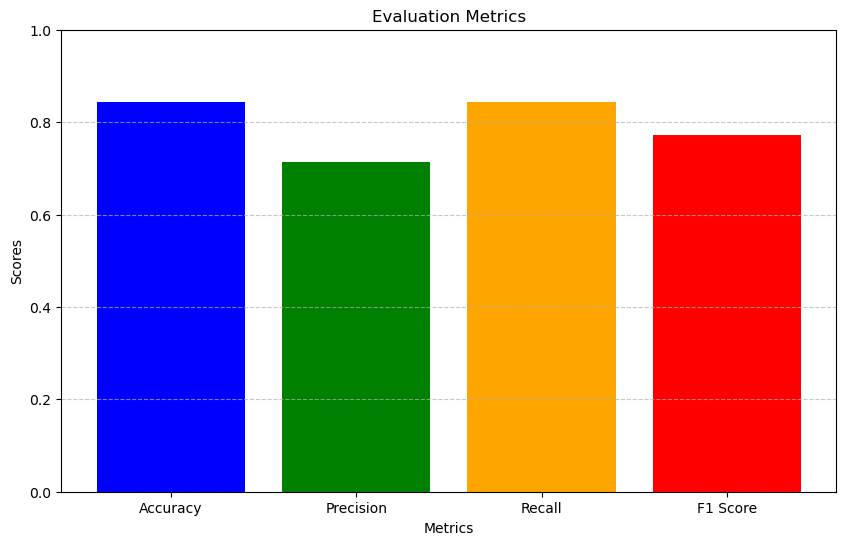

In [19]:
# Metrics
output_dir = 'Evaluating Metrics Output'
os.makedirs(output_dir, exist_ok=True)

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
scores = [accuracy, precision, recall, f1]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(metrics, scores, color=['blue', 'green', 'orange', 'red'])
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Evaluation Metrics')
plt.ylim(0, 1)  # Set y-axis limit to range [0, 1]
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig(os.path.join(output_dir, 'evaluation_metrics.png'))
plt.show()